In [60]:
pip install torch torchvision tqdm scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [61]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import numpy as np

# Device

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


# Seed

In [63]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior (important for reproducibility)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
set_seed(42)

# Collect image paths

In [64]:
def collect_paths(dataset_dir):
    dataset_dir = Path(dataset_dir)

    # Validate folders 0–9 exist
    for i in range(10):
        if not (dataset_dir / str(i)).exists():
            raise FileNotFoundError(f"Missing folder: {dataset_dir}/{i}")

    items = []
    for label in range(10):
        for img_path in sorted((dataset_dir / str(label)).glob("*.png")):
            items.append((str(img_path), label))

    if len(items) == 0:
        raise RuntimeError(f"No images found in {dataset_dir}")

    return items

# Dataset class

In [65]:
class DigitsDataset(Dataset):
    def __init__(self, items, transform):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("RGB")  # grayscale → 3-channel
        img = self.transform(img)
        return img, label

# Transforms (ImageNet normalization)

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# Dataloaders

In [66]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def make_loaders(items, batch_size=32, seed=42):
    labels = [y for _, y in items]

    # Reproducible train/val split
    train_items, val_items = train_test_split(
        items,
        test_size=0.2,
        stratify=labels,
        random_state=seed
    )

    train_ds = DigitsDataset(train_items, train_tfms)
    val_ds   = DigitsDataset(val_items, val_tfms)

    # Reproducible shuffling order in DataLoader
    g = torch.Generator()
    g.manual_seed(seed)

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        generator=g
    )

    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False
    )

    return train_dl, val_dl

# Build pretrained ResNet-18

In [67]:
def build_resnet18(num_classes=10, freeze_backbone=True):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Training + Evaluation

In [68]:
def accuracy(logits, labels):
    return (logits.argmax(1) == labels).float().mean().item()

def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, acc_sum, n = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            bs = x.size(0)
            loss_sum += loss.item() * bs
            acc_sum += accuracy(logits, y) * bs
            n += bs

    return loss_sum / n, acc_sum / n

def train(model, train_dl, val_dl, epochs, lr, weight_decay=0.0, show_progress=True, print_epoch_lines=False):
    """
    Returns:
      model, history
    history = {
      "train_loss": [...],
      "train_acc":  [...],
      "val_loss":   [...],
      "val_acc":    [...],
    }
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=weight_decay
    )

    def acc_from_logits(logits, y):
        return (logits.argmax(dim=1) == y).float().mean().item()

    @torch.no_grad()
    def evaluate_once():
        model.eval()
        loss_sum, acc_sum, n = 0.0, 0.0, 0
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            bs = x.size(0)
            loss_sum += loss.item() * bs
            acc_sum += acc_from_logits(logits, y) * bs
            n += bs
        return loss_sum / n, acc_sum / n

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_state, best_val_acc = None, -1.0

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss_sum, tr_acc_sum, n = 0.0, 0.0, 0

        iterator = train_dl
        if show_progress:
            iterator = tqdm(train_dl, desc=f"Epoch {ep}/{epochs}", leave=False)

        for x, y in iterator:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            bs = x.size(0)
            tr_loss_sum += loss.item() * bs
            tr_acc_sum  += acc_from_logits(logits, y) * bs
            n += bs

        train_loss = tr_loss_sum / n
        train_acc  = tr_acc_sum / n
        val_loss, val_acc = evaluate_once()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # No more per-epoch "Epoch X: val acc = ..." unless you want it
        if print_epoch_lines:
            print(f"Epoch {ep}: val acc = {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

# Evaluate on exchanged dataset

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch
from torch.utils.data import DataLoader

@torch.no_grad()
def evaluate_exchanged(model, dataset_dir):
    items = collect_paths(dataset_dir)
    ds = DigitsDataset(items, val_tfms)
    dl = DataLoader(ds, batch_size=32, shuffle=False)

    all_preds, all_labels = [], []
    model.eval()

    for x, y in dl:
        x = x.to(device)
        preds = model(x).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(y.numpy().tolist())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Exchanged dataset accuracy: {acc:.2f}\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return acc

# Plot function

In [70]:
import matplotlib.pyplot as plt

def plot_val_acc_with_metrics(hist_frozen, hist_ft=None, exchanged_acc=None):
    """
    - Adds a legend for Frozen vs Fine-tune
    - Writes key metrics on the plot (best/final val acc, exchanged acc)
    - No hardcoded epoch values; uses history dicts.
    """
    val1 = hist_frozen["val_acc"]
    x1 = list(range(1, len(val1) + 1))

    plt.figure()
    plt.plot(x1, val1, marker="o", label="Frozen (val acc)")

    # label each point with its val acc
    for x, y in zip(x1, val1):
        plt.text(x, y, f"{y:.2f}", ha="center", va="bottom")

    all_val = list(val1)

    if hist_ft is not None:
        val2 = hist_ft["val_acc"]
        offset = len(val1)
        x2 = list(range(offset + 1, offset + len(val2) + 1))
        plt.plot(x2, val2, marker="o", label="Fine-tune (val acc)")

        for x, y in zip(x2, val2):
            plt.text(x, y, f"{y:.2f}", ha="center", va="bottom")

        all_val += list(val2)

    # ---- Metrics text box ----
    best_val = max(all_val) if all_val else None
    final_val = all_val[-1] if all_val else None

    lines = []
    if best_val is not None:
        lines.append(f"Best Val Acc: {best_val:.2f}")
    if final_val is not None:
        lines.append(f"Final Val Acc: {final_val:.2f}")
    if exchanged_acc is not None:
        lines.append(f"Exchanged Acc: {exchanged_acc:.2f}")

    metrics_text = "\n".join(lines)
    if metrics_text:
        plt.gca().text(
            0.02, 0.98, metrics_text,
            transform=plt.gca().transAxes,
            va="top", ha="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
        )

    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy per Epoch")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.show()


# Main

In [71]:
# =========================
# MAIN
# =========================

# 1) Collect dataset paths
items = collect_paths("ML-Hands-on-Activity/LT01_digits")

# 2) Create DataLoaders (seeded split + seeded shuffle)
train_dl, val_dl = make_loaders(
    items,
    batch_size=32,
    seed=42
)

# =========================
# TRAINING PHASES
# =========================

# Phase 1: frozen backbone
model = build_resnet18(num_classes=10, freeze_backbone=True).to(device)
model, hist_frozen = train(model, train_dl, val_dl, epochs=10, lr=1e-3)

# Phase 2: fine-tuning
for name, p in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        p.requires_grad = True

model, hist_ft = train(model, train_dl, val_dl, epochs=5, lr=1e-4)

# =========================
# EVALUATION + PLOTTING
# =========================

exchanged_acc = evaluate_exchanged(
    model,
    "ML-Hands-on-Activity/LT10_digits"
)

Exchanged dataset accuracy: 0.31

Classification Report:
              precision    recall  f1-score   support

           0     0.5714    0.4000    0.4706        10
           1     0.0000    0.0000    0.0000        10
           2     0.5000    0.1000    0.1667        10
           3     0.0000    0.0000    0.0000        10
           4     0.4000    0.4000    0.4000        10
           5     1.0000    0.1000    0.1818        10
           6     0.2083    1.0000    0.3448        10
           7     0.3125    0.5000    0.3846        10
           8     1.0000    0.2000    0.3333        10
           9     0.5714    0.4000    0.4706        10

    accuracy                         0.3100       100
   macro avg     0.4564    0.3100    0.2752       100
weighted avg     0.4564    0.3100    0.2752       100

Confusion Matrix:
[[ 4  0  0  0  0  0  5  0  0  1]
 [ 0  0  1  2  1  0  1  5  0  0]
 [ 0  1  1  2  1  0  3  2  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  1  4  0  1  3  0  1]
 

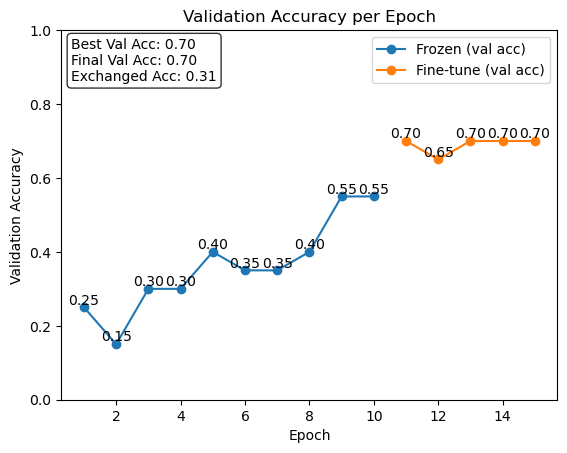

In [72]:
plot_val_acc_with_metrics(
    hist_frozen,
    hist_ft,
    exchanged_acc=exchanged_acc
)